# DATA JA RAJAPINTA TYÖPAJA - 19.2.2025

## Työpajaohjeistus
Työpajan tarkoituksena on opettaa Jupyter Notebooksin käyttöä datan analysointiin ja visualisointiin, sekä näyttää kuinka dataa voidaan hakea rajapinnasta.

Työpaja on jaettu kolmeen osaan:
1. Datan analysointi
2. Datan visualisointi
3. Datan hakeminen rajapinnan kautta

Työpajan aikana voi kysyä apua asiantuntijoilta.


## Työpaja osa - 1
Tiedostoista löytyy kahden kunnan, Kauhajoen ja Hämeenlinnan, vuoden 2023 ostolaskut. Tehtävänäsi on käydä läpi dataa (.csv tiedostot) ja valita "tilin nimi" sarakkeesta saman nimiset tai lähellä toisiaan olevat tilit.

Seuraavaksi tehtävänäsi on analysoida kustannuksia näiden kahden kunnan välillä. Esim. kuinka paljon kustannuksia on kuljetuspalveluissa tai paljonko rahaa menee sivistykseen.

## Esimerkki 1
Summataan vuoden aikana kertyneet ostolaskut tilin nimen perusteella.

In [12]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#Laajennetaan matplotlibin käyrien kokoa
plt.rcParams['figure.figsize'] = [30, 15]

def analyze_invoices():
    invoices = pd.read_csv('./kauhajoen-kaupunki_ostolaskut_2023.csv', encoding='windows-1252', sep=';')
    return invoices.groupby('Tilin nimi')
#analyze_invoices()


# Ladataan tietojoukot omiin dataframeihin ja suoritetaan esikäsittely

#Datan lataus CSV-tiedostosta, huomioi encoding jolla varmistetaan että myös ääkköset toimivat oikein
kauhajoki_df = pd.read_csv("./kauhajoen-kaupunki_ostolaskut_2023.csv", encoding='windows-1252', sep=';')
hameenlinna_df = pd.read_csv("./Ostolaskut_2023_julkaisu_hämeenlinna.csv", encoding='windows-1252', sep=';')

#Pudota kolumnit joissa on Unnamed nimessä, yleensä nämä ovat NaN tai turhia kolumneja
#kauhajoki_df = kauhajoki_df.loc[:, ~kauhajoki_df.columns.str.contains('^Unnamed')]
#Pudota NaN arvot
#df.dropna(how='all')


#Datan esikäsittely ja yhtenäistäminen
"""
Hämeenlinnan tositepvm ovat muotoa dd.mm.yyyy hh:mm (esim, 19.2.2025 11:00) joten päivämäärän saamiseksi voidaan kolumnin arvosta leikata tunnit ja minuutit poist
(str[:-5], jossa -5 tarkoittaa viittä viimeisintä kirjainta (esim 19.2.2025 11:00 -> 19.2.2025
"""
hameenlinna_df['Laskun päivämäärä'] = pd.to_datetime(hameenlinna_df['Kirjauspvm'].astype(str).str[:-5], dayfirst=True)

#Otetaan kuukausi talteen omaan kolumniin helpottamaan kuukausipohjaista analyysia
hameenlinna_df['Kuukausi'] = hameenlinna_df['Laskun päivämäärä'].dt.month

"""
 Kauhajoen datassa päivämäärät ovat omassa muodossaan, joten ne joudutaan manuaalisesti käsittelemään
 Koska päivämäärät ovat muotoa DDMMYY (19022025) ja päivissä ei ole nollaa alussa, joudutaan semmonen lisäämään
 Datan päivämäärän maksimipituus on 8 merkkiä ja koska tiedämme että nolla puuttuu vain alusta, voidaan sellainen lisätä seuraavalla tavalla
"""
kauhajoki_df['Tositepvm'] = kauhajoki_df['Tositepvm'].astype(str).str.zfill(8) #lisätään nollia alkuun kunnes rivin tositepvm pituus on 8 merkkiä


#Koska päivämäärät ovat samaa muotoa, eli 2 ensimmäistä kirjainta kertoo päivän, seuraavat 2 kuukauden ja loput 4 vuoden, niin kuukausi saadaan seuraavalla tavalla
kauhajoki_df['Kuukausi'] = kauhajoki_df['Tositepvm'].astype(str).str[3:4] #Muuta tekstityypiksi ja leikkaa kirjaimet numero 3 ja 4, jotka vastaavat kuukautta

#Hämeenlinnan datassa on mukana myös reklamaatiot (Euroa-kolumni positiivinen), joten suodatetaan ne pois
hameenlinna_df = hameenlinna_df[hameenlinna_df['Euroa'].astype(str).str.contains("-")] #Tarkistaa että alkaako rivi miinusmerkillä, joka viittaa kuluun
hameenlinna_df['Euroa'] = hameenlinna_df['Euroa'].astype(str).str.replace('-', '') #Poistetaan miinusmerkki laskuja sekoittamasta
hameenlinna_df['Euroa'] = hameenlinna_df['Euroa'].str.replace(',', '.').astype(float) #Korvataan summan pilkku pisteellä ja muutetaan numeroksi (float)

In [13]:
#Lasketaan että kuinka paljon kunnat ovat käyttäneet vuoden aikana eri palveluihin rahaa bruttona

hameenlinna_palvelut = pd.DataFrame({'Summa': hameenlinna_df.groupby(['Tilin nimi'])['Euroa'].sum()}).reset_index().sort_values('Summa', ascending=False)
kauhajoki_palvelut = pd.DataFrame({'Summa': kauhajoki_df.groupby(['Tilin nimi'])['Rivin bruttosumma'].sum()}).reset_index().sort_values('Summa', ascending=False)

#Valitaan top 5 laskuttajaa
hameenlinna_top5 = hameenlinna_palvelut.head(5)
kauhajoki_top5 = kauhajoki_palvelut.head(5)
print("---Hämeenlinna Top 5---")
print(hameenlinna_top5)

print("---Kauhajoki Top 5---")
print(kauhajoki_top5)

---Hämeenlinna Top 5---
                                       Tilin nimi        Summa
12  43900 Rak. ja alueiden rakent.ja kun.pit.palv  39300988.93
53      48200 Rakennusten ja huoneistojen vuokrat   8761428.07
17                         44170 Kuljetuspalvelut   8305901.26
4                      43410 Asiantuntijapalvelut   7040409.80
16                       44140 Ravitsemispalvelut   6896893.62
---Kauhajoki Top 5---
                                  Tilin nimi        Summa
34      Kuntatod. Kuntarahoitus Oy:ltä (l.a)  60500000.00
22    Keskener.hankinnat muiden rak.uudisrak   5377401.89
38   Lyhennysosuudet/kotim.rah.laitok. (l.a)   5323370.00
30                    KuEL-maksu/ työnantaja   3662746.14
21  Keskener.hank. kiinteät rak. ja laitteet   2458790.08


In [14]:
#Verrataan keskenään kuinka paljon nämä kunnat ovat käyttäneet kuljetuspalveluihin rahaa

#Koska molemmissa tiedoissa kuljetuspalvelut on nimetty suurinpiirtein samalla tavalla, voidaan tehdä vain tarkistus että onko Tilin nimessä sana "Kuljetutus
kuljetuspalvelut_kauhajoki = kauhajoki_palvelut[kauhajoki_palvelut['Tilin nimi'].astype(str).str.contains('Kuljetus')]
kuljetuspalvelut_hameenlinna = hameenlinna_palvelut[hameenlinna_palvelut['Tilin nimi'].astype(str).str.contains('Kuljetus')]

#Tulostus
print("---Kauhajoki---")
print(kuljetuspalvelut_kauhajoki)
print("---Hämeenlinna---")
print(kuljetuspalvelut_hameenlinna)

---Kauhajoki---
          Tilin nimi       Summa
32  Kuljetuspalvelut  1461571.64
---Hämeenlinna---
                Tilin nimi       Summa
17  44170 Kuljetuspalvelut  8305901.26


## Työpaja Osa - 2
Seuraavaksi visualisoimme edellisessä analyysissä olevia tietoja, jolloin niistä tulee helpommin hahmotettavia. Tässä käytetään x-kirjastoa datan visualisointiin.

Tehtävänäsi on luoda kuvaajat datalle, jossa verrataan molempien kuntien top 5 kuluja.

# Esimerkki 2

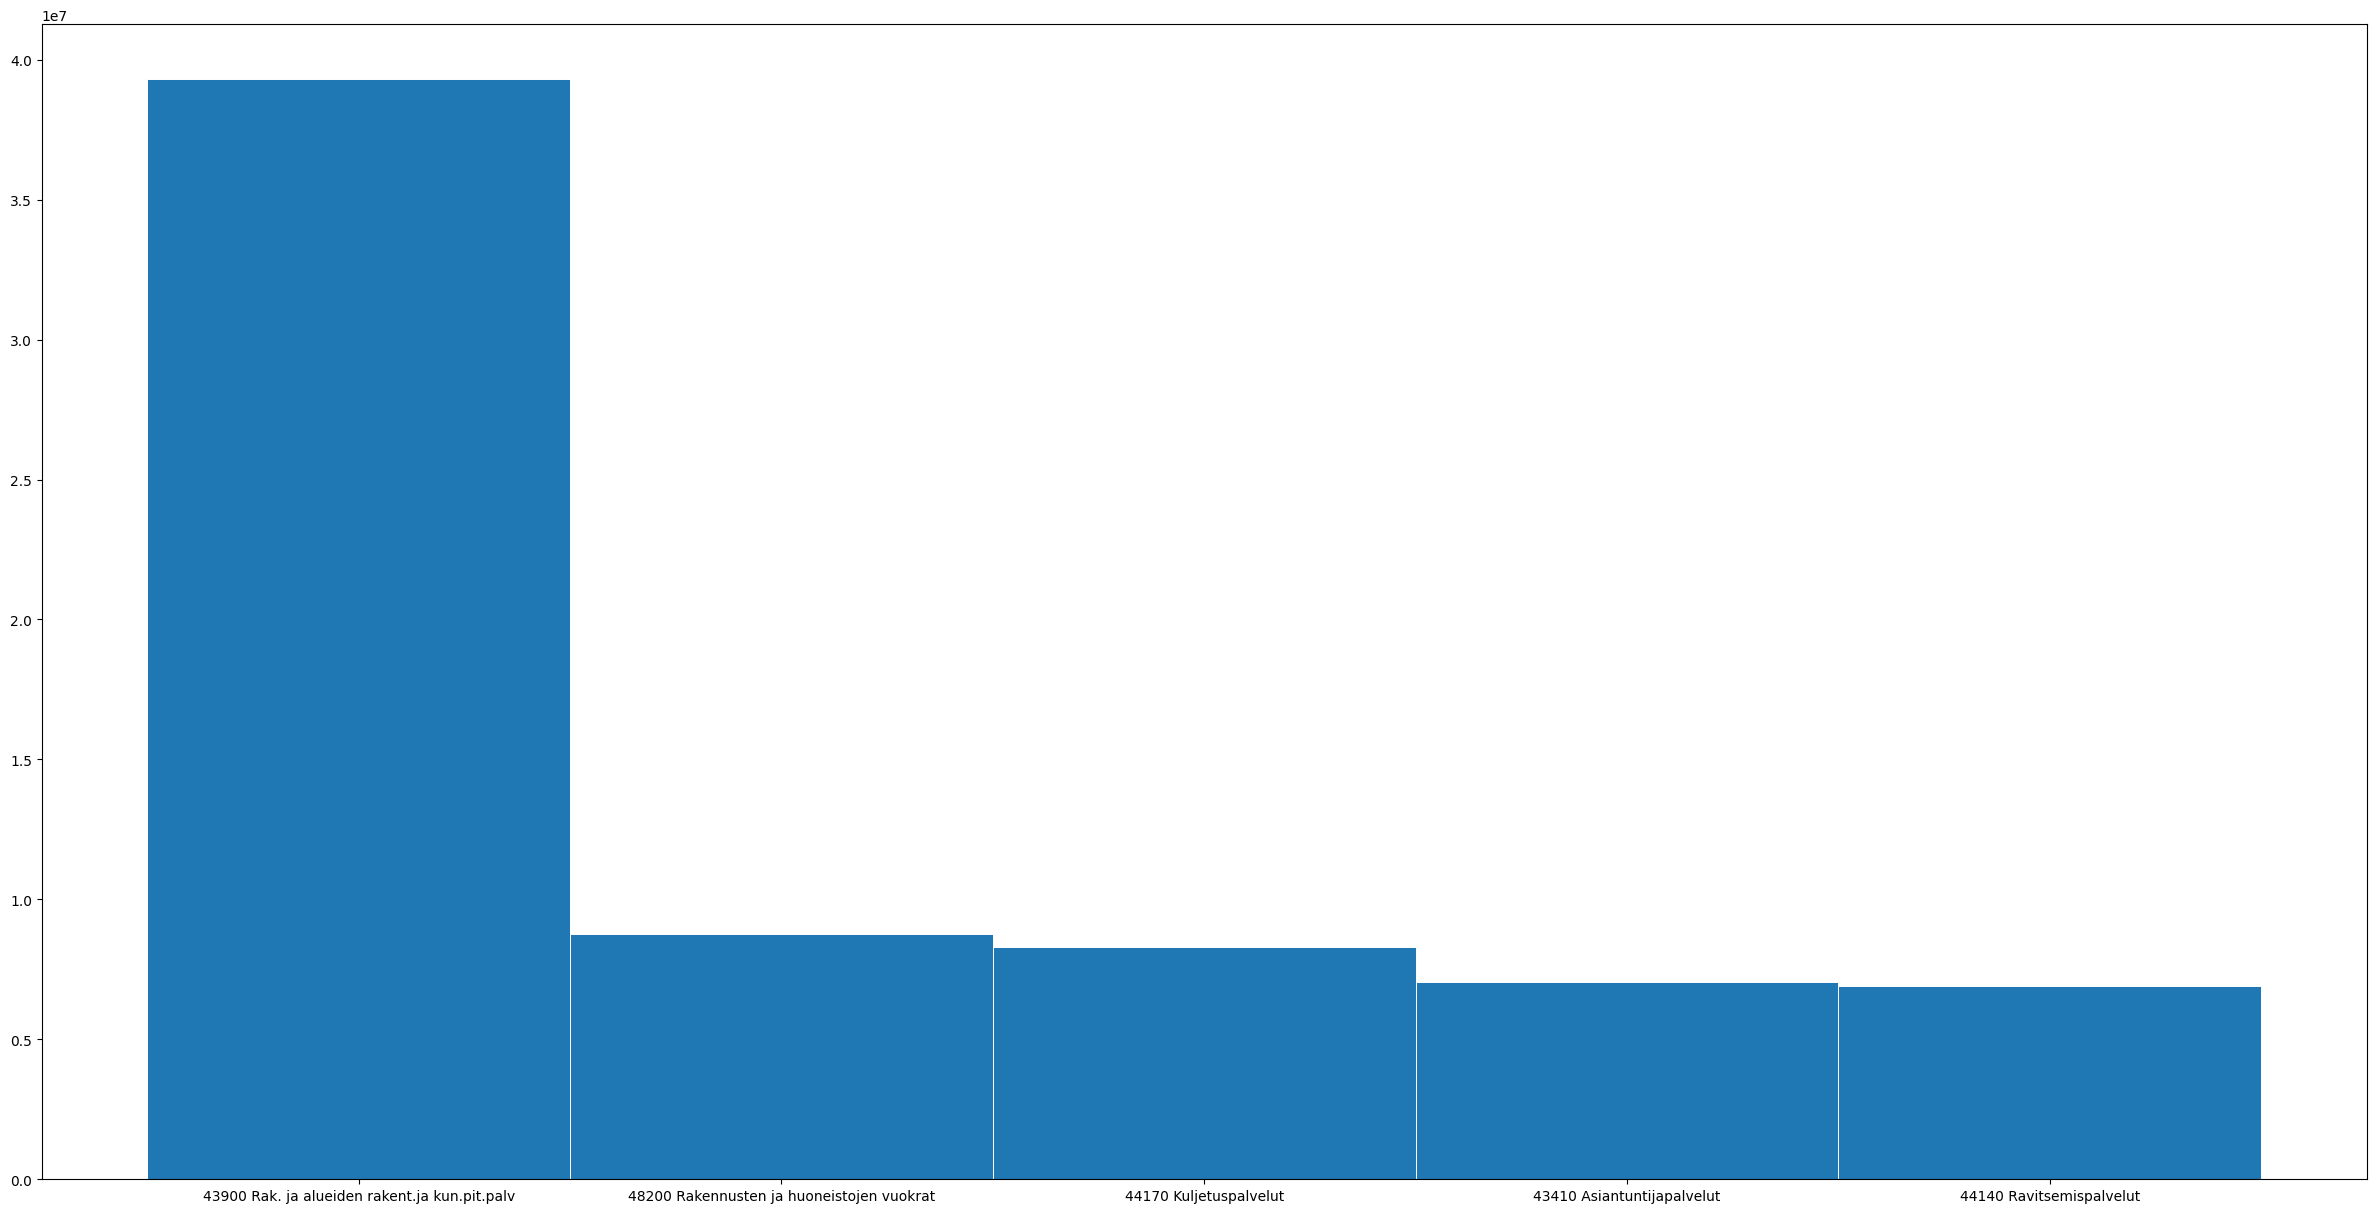

In [15]:
#Luodaan palkkikaavio, jossa X-akselilla on tilin nimi ja Y-akselilla summa

#Hämeenlinna
hl_x = hameenlinna_top5['Tilin nimi']
hl_y = hameenlinna_top5['Summa']
fig, ax = plt.subplots()

ax.bar(hl_x, hl_y, width=1, edgecolor="white", linewidth=0.7)

plt.show()

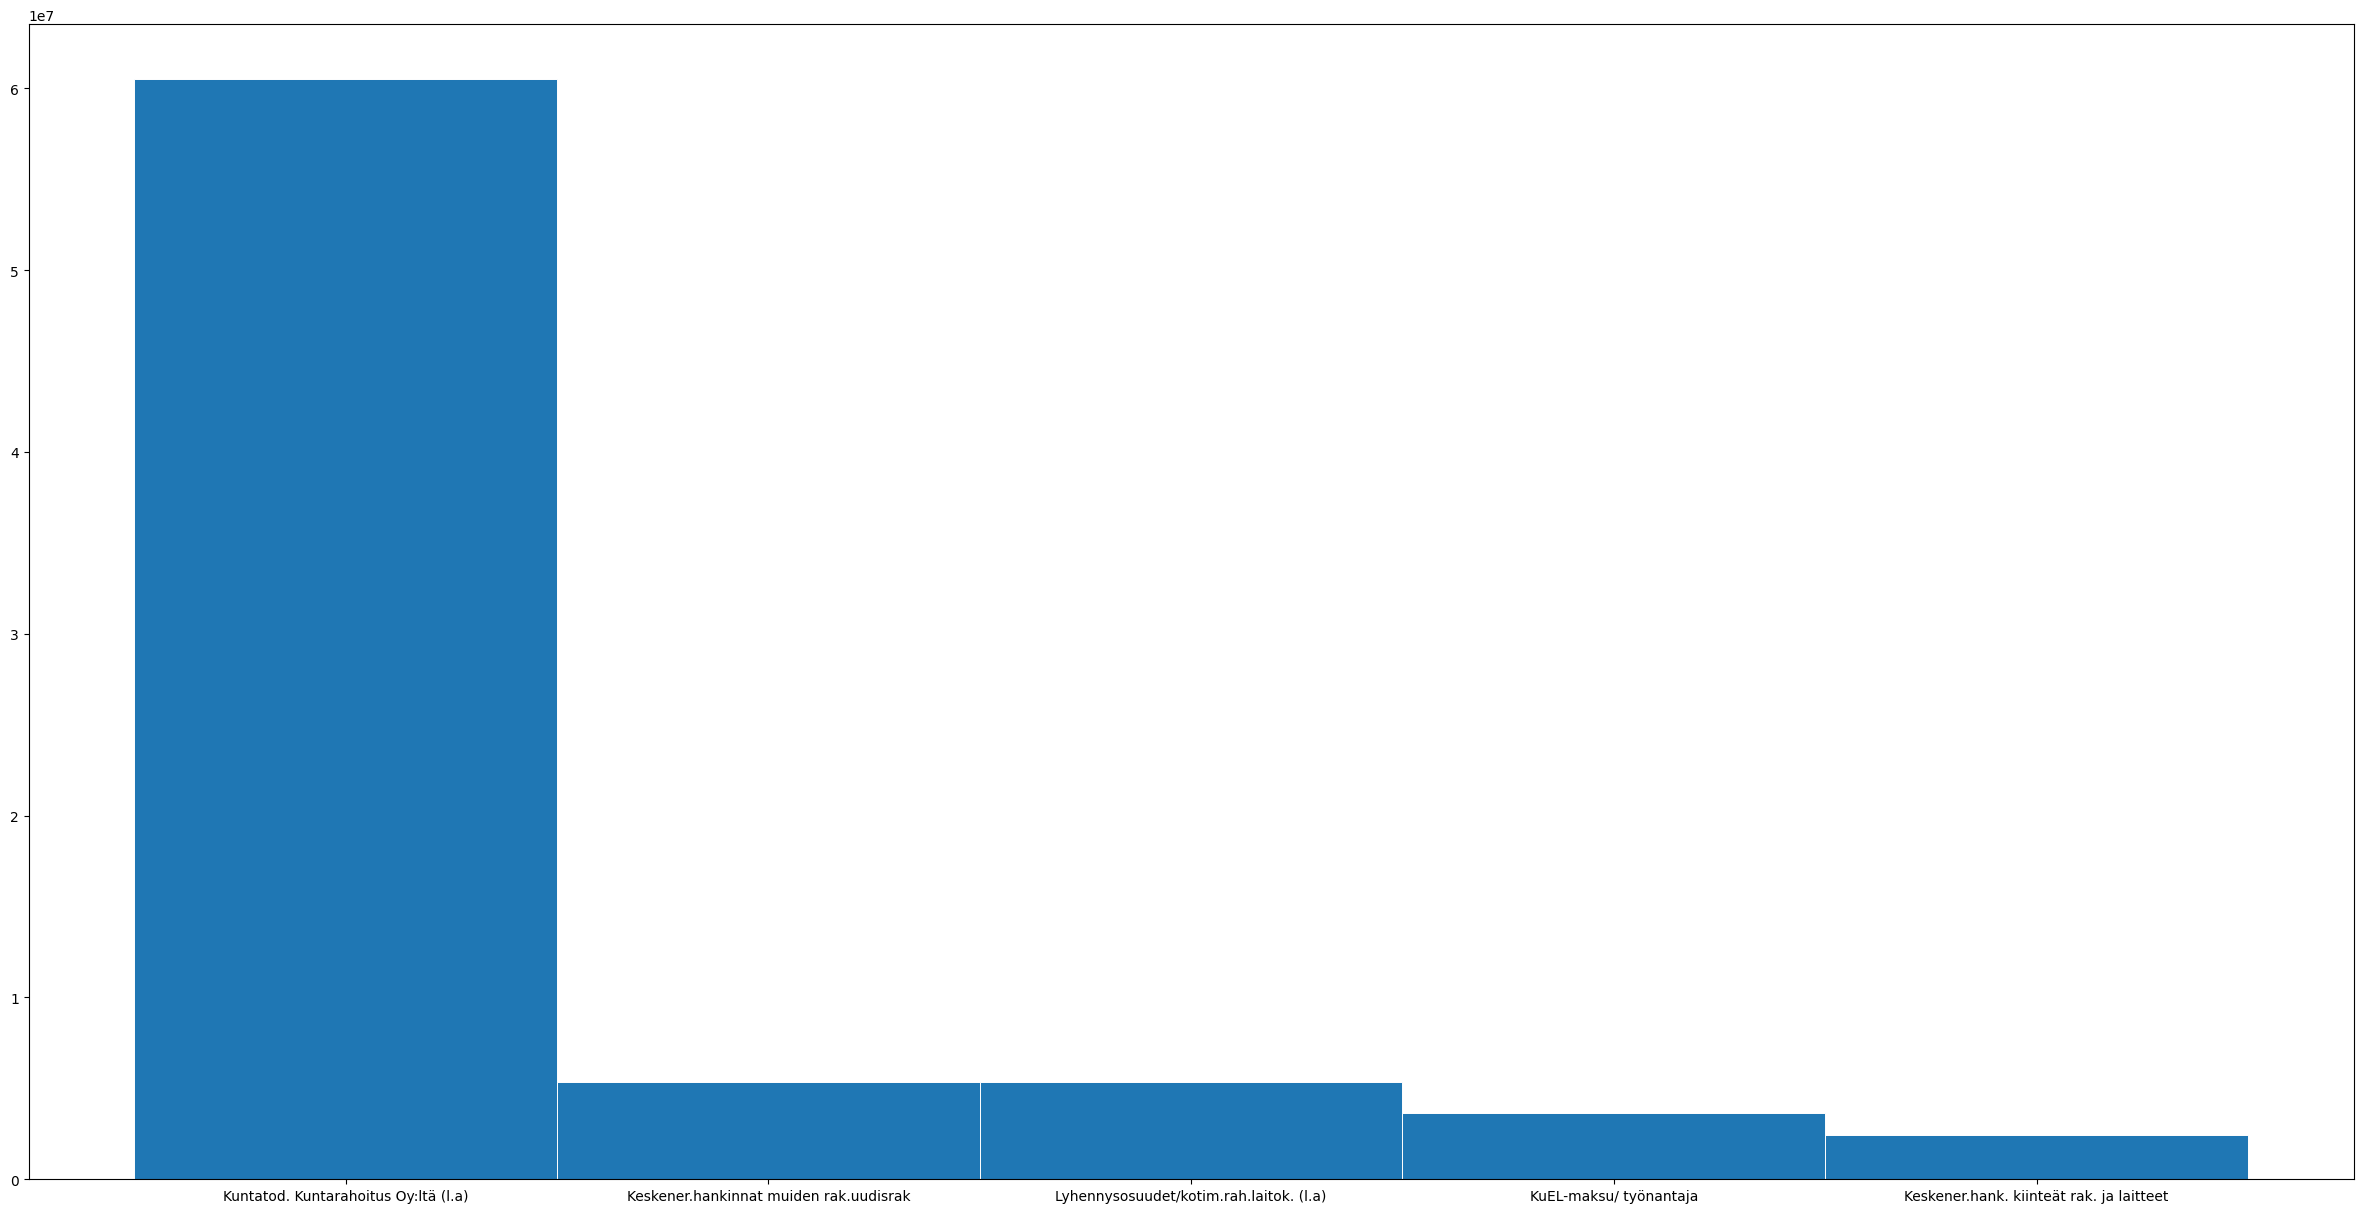

In [16]:
#Kauhajoki
kj_x = kauhajoki_top5['Tilin nimi']
kj_y = kauhajoki_top5['Summa']
fig, ax = plt.subplots()

ax.bar(kj_x, kj_y, width=1, edgecolor="white", linewidth=0.7)

plt.show()

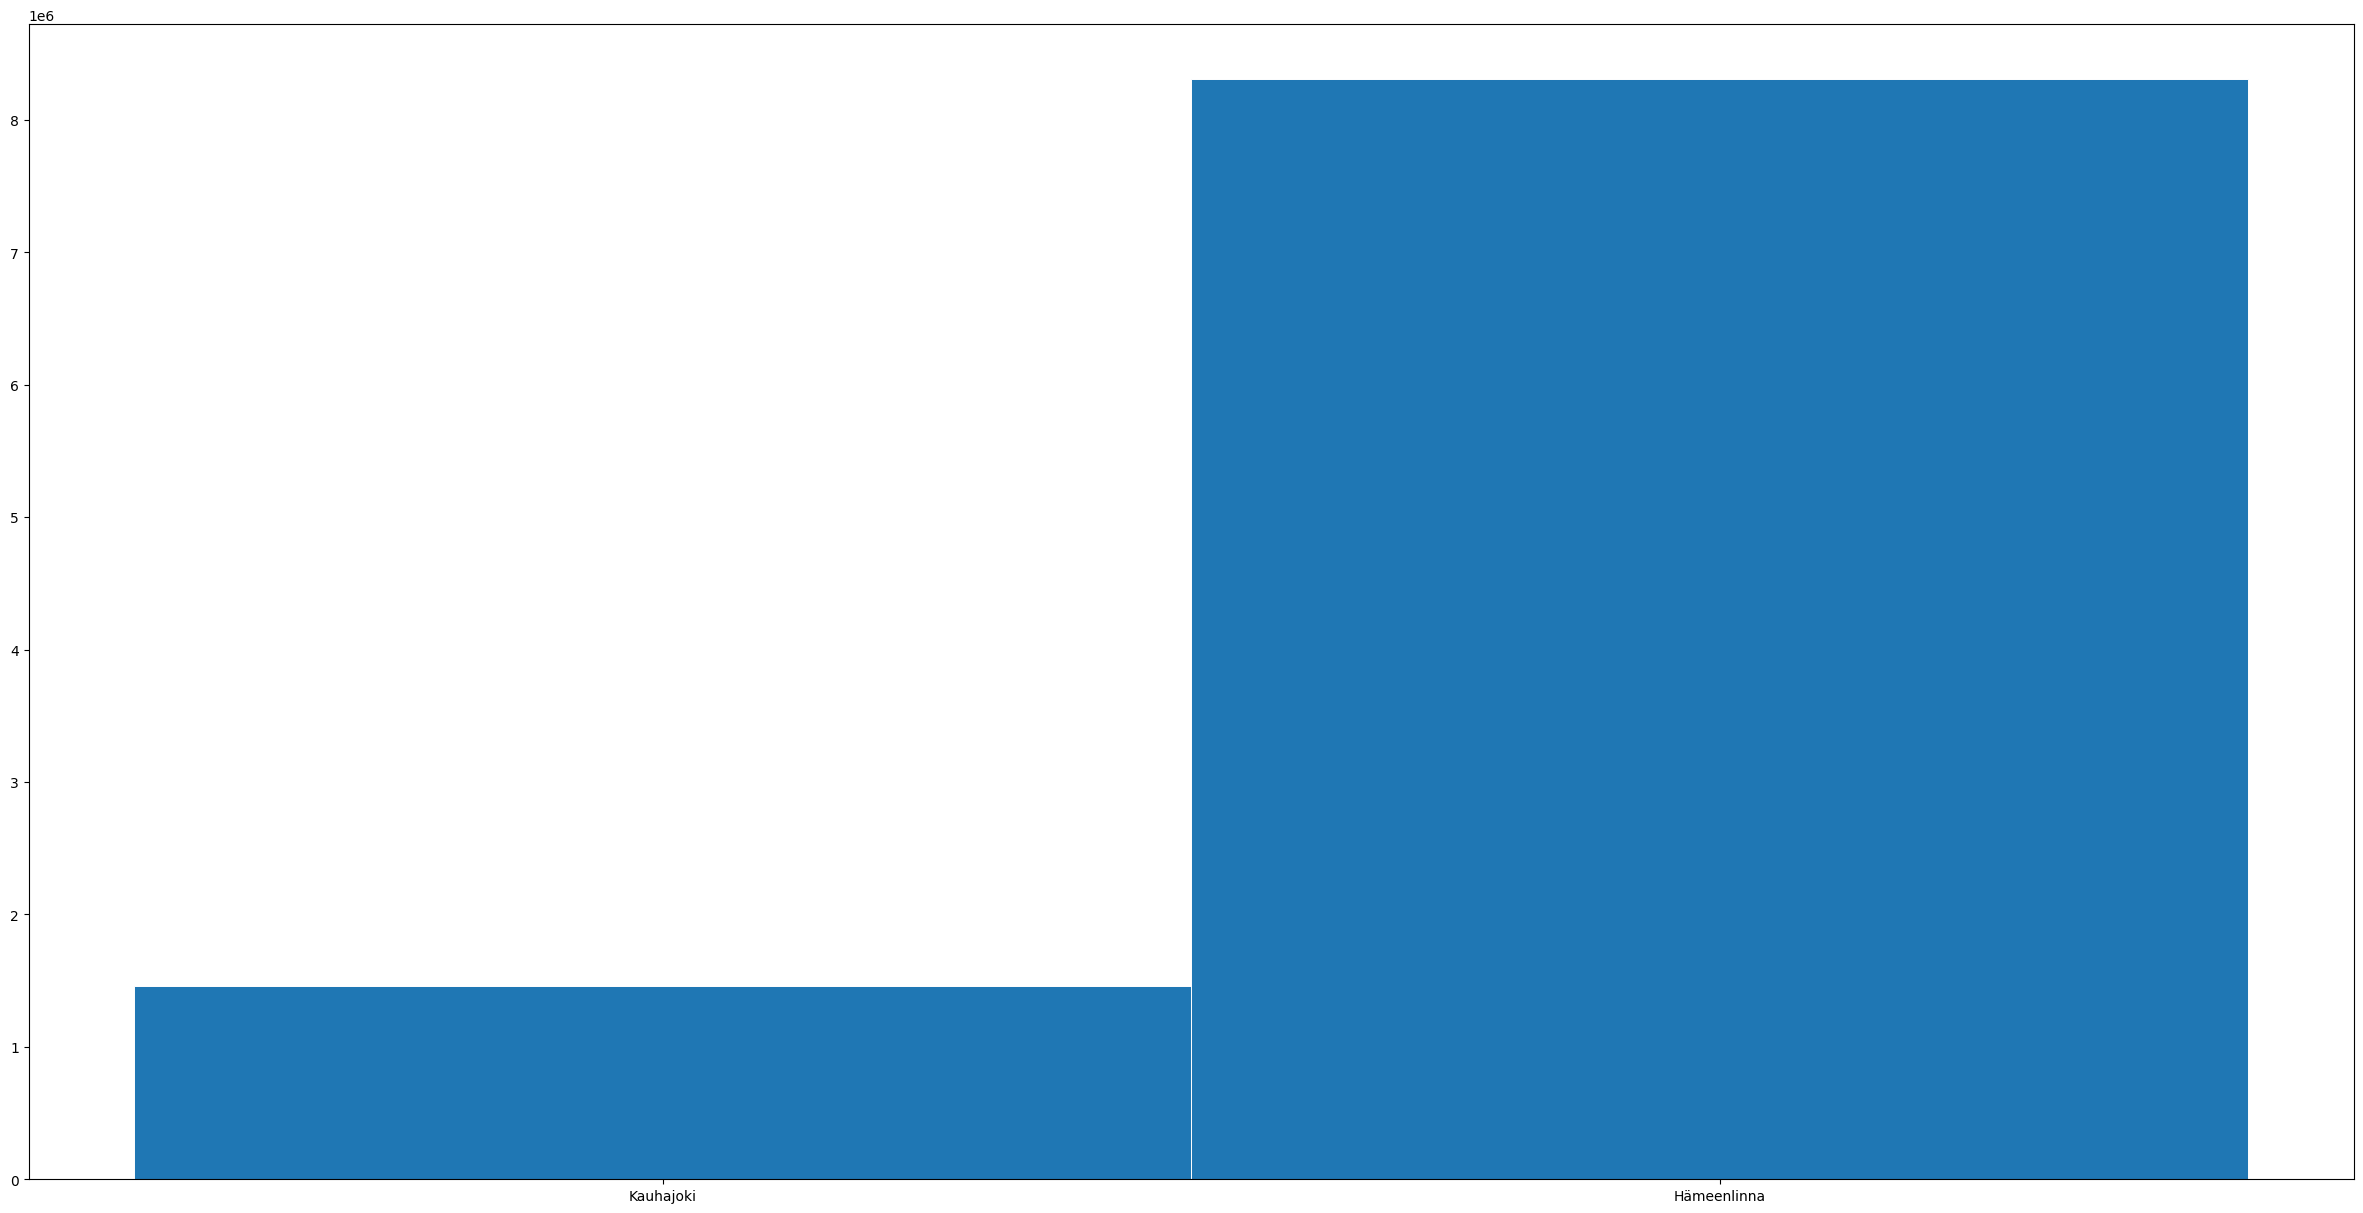

In [17]:
#Kuljetuspalveluiden summien vertaaminen keskenään

#Muutetaan data numpy-arrayksi, joka tietyssä tapauksissa helpottaa datan käsittelyä
kauhajoki_np = kuljetuspalvelut_kauhajoki.to_numpy()
hameenlinna_np = kuljetuspalvelut_hameenlinna.to_numpy()

#Nämä numpy-arrayt ovat muotoa [[paikkakunta, summa]] eli ns "nested array", joka tarkoittaa että se on taulu jonka sisällä on tauluja
#Jotta päästään käsiksi esimerkiksi y-arvoon, joudutaan ilmoittamaan myös missä taulussa kyseinen arvo
#Koska tässä taulussa on vain yksi sisäinen taulu, voidaan sen indeksi kovakoodata 0:ksi, jonka y-arvoon päästään käsiksi kirjoittamalla kauhajoki_np[0][1]

#Otetaan Kauhajoen ja Hämeenlinnan summat
kp_y = [kauhajoki_np[0][1],hameenlinna_np[0][1]]

#Annetaan nimet numeroille. Huomioi että arvot ovat samassa järjestyksessä
kp_x = ['Kauhajoki', 'Hämeenlinna']

#Vaihtoehtoinen tapa, jossa myös nimet otetaan numpy-arraysta
#kp_y = [kauhajoki_np[0][0],hameenlinna_np[0][0]]

#Luodaan kaavio
fig, ax = plt.subplots()
#ax.bar = palkkikaavio
ax.bar(kp_x, kp_y, width=1, edgecolor="white", linewidth=0.7)
plt.show()

## Työpaja osa - 3
Seuraavaksi rikastutamme dataamme lisää hakemalla asukasmäärät kunnille Tilastokeskuksen rajapinnasta. Sen jälkeen laskemme kustannukset per asukas kuljetuspalveluille ja vertaamme niitä toisiinsa.

In [ ]:
import requests
import json

#Haetaan Hämeenlinnan ja Kauhajoen väkiluvut
#Rajapinta mahdollistaa datan hakemisen JSON-muodossa, joka on helppo käsitellä Pythonissa
def get_population():
    url = 'https://pxdata.stat.fi:443/PxWeb/api/v1/fi/Kuntien_avainluvut/2023/kuntien_avainluvut_2023_viimeisin.px'
    data = json.dumps({"query": [{"code": "Alue","selection": {"filter": "agg:_- Kunnat aakkosjärjestyksessä 2023.agg","values": ["KU109","KU232"]}},{"code": "Tiedot","selection": {"filter": "item","values": ["M411"]}}],"response": {"format": "json-stat2"}})
    headers = {'Content-Type': 'application/json'}
    r = requests.post(url, headers=headers, data=data)
    r.raise_for_status()
    result = r.json()
    return result['value'] # Palauttaa listan, jossa on kaksi arvoa: Hämeenlinnan ja Kauhajoen väkiluvut

#Käytetään funktiota ja otetaan väkiluvut talteen
population = get_population()

#Lasketaan kuljetuspalveluiden summa per asukas
kauhajoki_population = kuljetuspalvelut_kauhajoki['Summa']/population[1]
hameenlinna_population = kuljetuspalvelut_hameenlinna['Summa']/population[0]

#Tulostetaan kuljetuspalveluiden summa per asukas
print("Kauhajoen kuljetuspalveluiden summa per asukas: ", kauhajoki_population.values[0])
print("Hämeenlinnan kuljetuspalveluiden summa per asukas: ", hameenlinna_population.values[0])


Kauhajoen kuljetuspalveluiden summa per asukas:  115.83227452845144
Hämeenlinnan kuljetuspalveluiden summa per asukas:  121.57527569197441


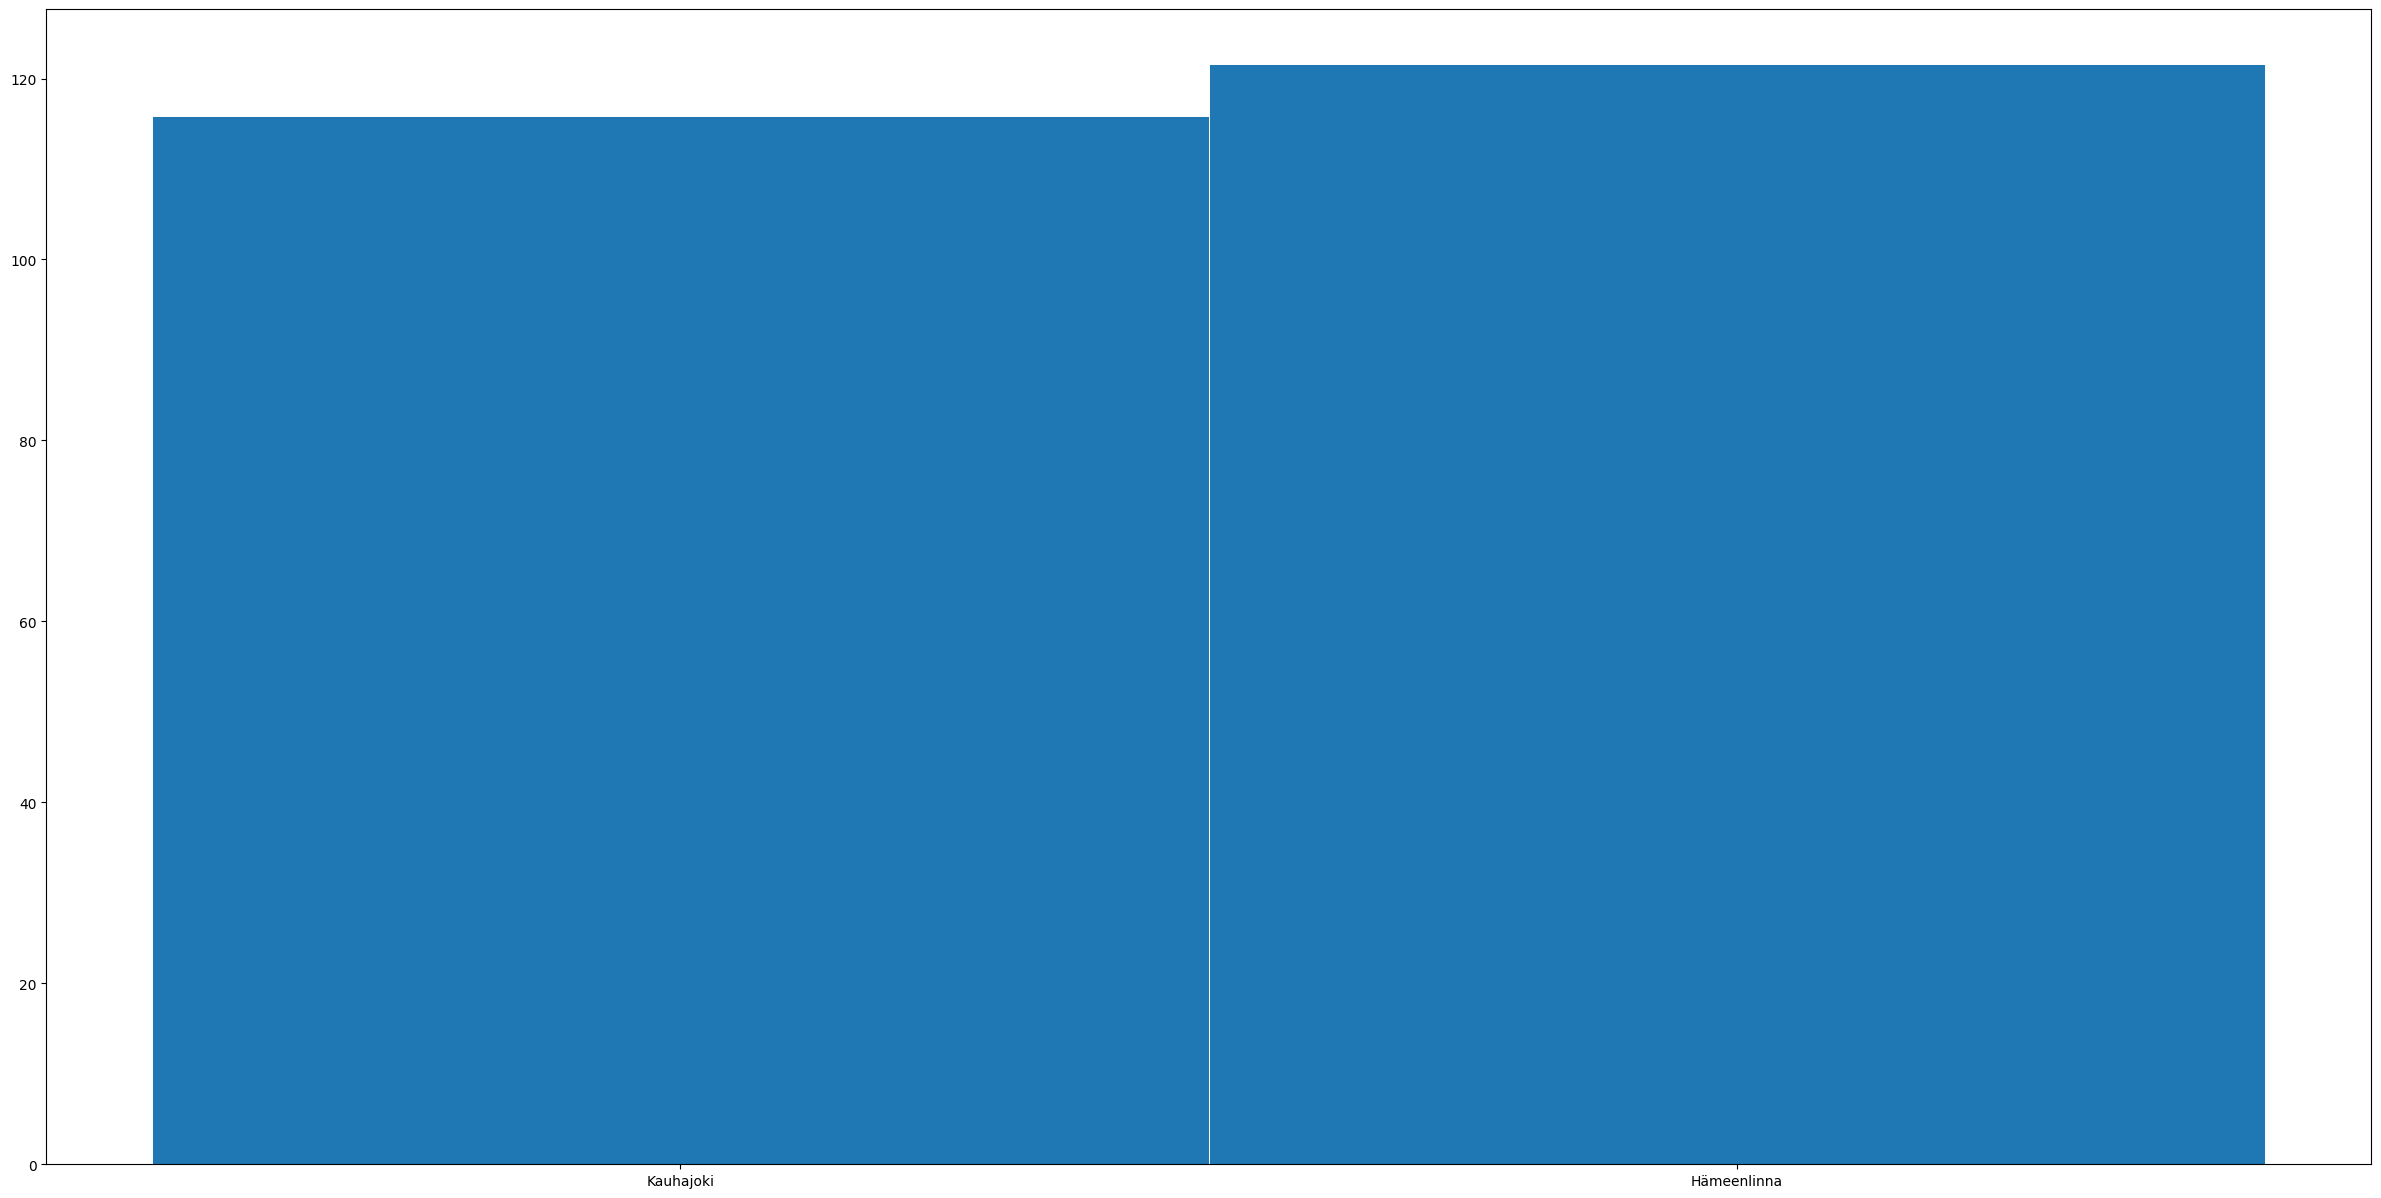

In [ ]:
#Seuraavaksi piirretään kuvaajaan nämä erot

#Otetaan Kauhajoen ja Hämeenlinnan summat
kp_y = [kauhajoki_population.values[0],hameenlinna_population.values[0]]

#Annetaan nimet numeroille. Huomioi että arvot ovat samassa järjestyksessä
kp_x = ['Kauhajoki', 'Hämeenlinna']

#Vaihtoehtoinen tapa, jossa myös nimet otetaan numpy-arraysta
#kp_y = [kauhajoki_np[0][0],hameenlinna_np[0][0]]

#Luodaan kaavio
fig, ax = plt.subplots()
#ax.bar = palkkikaavio
ax.bar(kp_x, kp_y, width=1, edgecolor="white", linewidth=0.7)
plt.show()